<a href="https://colab.research.google.com/github/Kubenew/ASI/blob/main/Copy_of_HRL7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Training Hierarchical RL...
Ep   0 | Reward:  18.86 | Avg20:  18.86 | Success: 1.00 | Eps: 0.656
Ep  20 | Reward:  -6.50 | Avg20:   5.09 | Success: 0.45 | Eps: 0.050
Ep  40 | Reward:  18.51 | Avg20:   6.35 | Success: 0.50 | Eps: 0.050
Ep  60 | Reward:  19.20 | Avg20:   6.40 | Success: 0.50 | Eps: 0.050
Ep  80 | Reward:  -6.50 | Avg20:   3.76 | Success: 0.40 | Eps: 0.050
Ep 100 | Reward:  19.50 | Avg20:   5.04 | Success: 0.45 | Eps: 0.050
Ep 120 | Reward:  19.55 | Avg20:   9.02 | Success: 0.60 | Eps: 0.050
Ep 140 | Reward:  19.13 | Avg20:   2.47 | Success: 0.35 | Eps: 0.050
Ep 160 | Reward:  -6.50 | Avg20:   1.22 | Success: 0.30 | Eps: 0.050
Ep 180 | Reward:  19.38 | Avg20:   5.16 | Success: 0.45 | Eps: 0.050

Training completed!


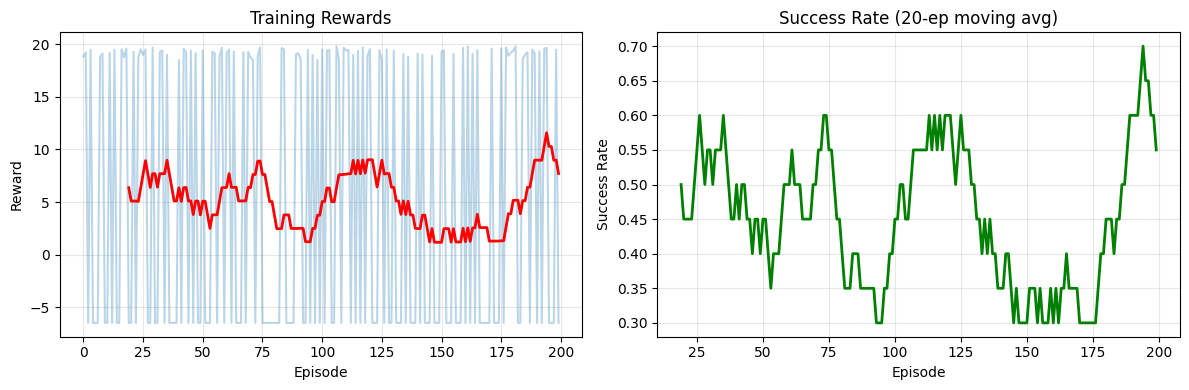


Final Results:
Average Reward: 5.22
Success Rate: 45.50%


In [1]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


class ProcGenGridWorld(gym.Env):
    """Procedural Grid World with obstacles"""

    def __init__(self, size=10, obstacle_prob=0.2):
        super().__init__()
        self.size = size
        self.obstacle_prob = obstacle_prob
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(0, size-1, (4,), dtype=np.float32)

    def reset(self, seed=None):
        """Reset environment with optional seeding"""
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)

        # Generate random obstacles
        self.grid = np.zeros((self.size, self.size))
        for i in range(self.size):
            for j in range(self.size):
                if random.random() < self.obstacle_prob:
                    self.grid[i, j] = 1

        # Set positions (ensure start and goal are free)
        self.agent_pos = np.array([0, 0], dtype=np.float32)
        self.goal_pos = np.array([self.size-1, self.size-1], dtype=np.float32)
        self.grid[0, 0] = 0
        self.grid[self.size-1, self.size-1] = 0
        self.steps = 0
        return self._get_obs()

    def _get_obs(self):
        """Return observation: [agent_x, agent_y, goal_x, goal_y]"""
        return np.concatenate([self.agent_pos, self.goal_pos]).astype(np.float32)

    def step(self, action):
        """Execute action and return (obs, reward, done, info)"""
        self.steps += 1

        # Action mapping: 0=Up, 1=Down, 2=Left, 3=Right
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = np.array(moves[action])
        new_pos = np.clip(self.agent_pos + move, 0, self.size-1)

        # Check collision
        if self.grid[int(new_pos[0]), int(new_pos[1])] == 0:
            self.agent_pos = new_pos

        # Calculate reward and termination
        dist = np.linalg.norm(self.agent_pos - self.goal_pos)
        reward = -0.01  # Step penalty
        done = False
        success = False

        if dist < 0.5:  # Goal reached
            reward = 20.0
            done = True
            success = True
        elif self.steps > 150:  # Timeout
            reward = -5.0
            done = True

        return self._get_obs(), reward, done, {'success': success}


class DQN(nn.Module):
    """Deep Q-Network"""

    def __init__(self, input_dim=4, output_dim=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class ReplayBuffer:
    """Experience Replay Buffer"""

    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)


class LowLevelAgent:
    """Low-level DQN agent for reaching subgoals"""

    def __init__(self):
        # Input: [agent_x, agent_y, subgoal_x, subgoal_y]
        self.policy = DQN(input_dim=4, output_dim=4)
        self.target = DQN(input_dim=4, output_dim=4)
        self.target.load_state_dict(self.policy.state_dict())

        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.buffer = ReplayBuffer()

        self.gamma = 0.99
        self.epsilon = 1.0
        self.eps_min = 0.05
        self.eps_decay = 0.995
        self.update_counter = 0
        self.target_update_freq = 50

    def act(self, state, subgoal, eval_mode=False):
        """Select action using epsilon-greedy"""
        if not eval_mode and random.random() < self.epsilon:
            return random.randint(0, 3)

        inp = torch.FloatTensor(np.concatenate([state[:2], subgoal])).unsqueeze(0)
        with torch.no_grad():
            return self.policy(inp).argmax().item()

    def train_step(self, batch_size=32):
        """Train the policy network"""
        if len(self.buffer) < batch_size:
            return 0.0

        # Sample batch
        states, actions, rewards, next_states, dones = self.buffer.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Compute Q values
        current_q = self.policy(states).gather(1, actions).squeeze()
        with torch.no_grad():
            next_q = self.target(next_states).max(1)[0]
            target_q = rewards + self.gamma * next_q * (1 - dones)

        # Update
        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target.load_state_dict(self.policy.state_dict())

        return loss.item()


class HighLevelController:
    """High-level controller that sets subgoals"""

    def select_subgoal(self, state):
        """Select waypoint between current position and goal"""
        pos = state[:2]
        goal = state[2:]
        direction = goal - pos

        # Random fraction along path with noise
        frac = random.choice([0.3, 0.5, 0.7])
        noise = np.random.uniform(-1.5, 1.5, 2)

        subgoal = pos + direction * frac + noise
        return np.clip(np.round(subgoal), 0, 9).astype(np.float32)


def train_hierarchical_rl(num_episodes=200):
    """Main training loop"""
    env = ProcGenGridWorld(size=10, obstacle_prob=0.2)
    hl_controller = HighLevelController()
    ll_agent = LowLevelAgent()

    rewards_history = []
    success_history = []

    print("Training Hierarchical RL...")

    for episode in range(num_episodes):
        state = env.reset(seed=SEED + episode)
        episode_reward = 0
        steps = 0
        done = False

        while not done and steps < 300:
            # High-level selects subgoal
            subgoal = hl_controller.select_subgoal(state)
            subgoal_reached = False
            subgoal_steps = 0

            # Low-level executes
            while not done and not subgoal_reached and subgoal_steps < 10:
                action = ll_agent.act(state, subgoal)
                next_state, reward, done, info = env.step(action)

                # Shaped reward for low-level
                shaped_reward = -np.linalg.norm(next_state[:2] - subgoal) * 0.1

                # Store transition
                current_obs = np.concatenate([state[:2], subgoal])
                next_obs = np.concatenate([next_state[:2], subgoal])
                ll_agent.buffer.push(current_obs, action, shaped_reward, next_obs, done)

                # Train
                ll_agent.train_step()

                state = next_state
                episode_reward += reward
                steps += 1
                subgoal_steps += 1

                if np.linalg.norm(state[:2] - subgoal) < 1.0:
                    subgoal_reached = True

            if done:
                break

        rewards_history.append(episode_reward)
        success_history.append(1 if info.get('success', False) else 0)

        if episode % 20 == 0:
            avg_reward = np.mean(rewards_history[-20:]) if len(rewards_history) >= 20 else np.mean(rewards_history)
            success_rate = np.mean(success_history[-20:]) if len(success_history) >= 20 else np.mean(success_history)
            print(f"Ep {episode:3d} | Reward: {episode_reward:6.2f} | Avg20: {avg_reward:6.2f} | "
                  f"Success: {success_rate:.2f} | Eps: {ll_agent.epsilon:.3f}")

    print("\nTraining completed!")
    return rewards_history, success_history, ll_agent


if __name__ == "__main__":
    rewards, successes, agent = train_hierarchical_rl(num_episodes=200)

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(rewards, alpha=0.3)
    if len(rewards) >= 20:
        moving_avg = np.convolve(rewards, np.ones(20)/20, mode='valid')
        plt.plot(range(19, len(rewards)), moving_avg, 'r-', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    if len(successes) >= 20:
        success_rate = np.convolve(successes, np.ones(20)/20, mode='valid')
        plt.plot(range(19, len(successes)), success_rate, 'g-', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.title('Success Rate (20-ep moving avg)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('hrl_training.png', dpi=150)
    plt.show()

    print(f"\nFinal Results:")
    print(f"Average Reward: {np.mean(rewards):.2f}")
    print(f"Success Rate: {np.mean(successes):.2%}")
